In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install scanpy


In [4]:
import scanpy as sc
import warnings

In [ ]:
!pip install PhenoGraph
import phenograph


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Setting up functions for all the steps:**

In [7]:
# Some plotting settings from Setty Lab
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [ ]:
#data_path = '/content/drive/My Drive/ENS-Monal/P21_1'


In [8]:
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import os

def load_and_merge_10x_manual(sample_paths, sample_names):
    """
    Manually loads and merges multiple 10x-formatted datasets into a single AnnData object.

    Parameters:
        sample_paths (list of str): List of full paths to folders with 10x files (matrix.mtx, barcodes.tsv, features.tsv)
        sample_names (list of str): Sample names corresponding to each path

    Returns:
        AnnData: Combined AnnData object with sample annotation
    """
    adata_list = []

    for path, sample in zip(sample_paths, sample_names):
        # Load files
        matrix = mmread(os.path.join(path, "matrix.mtx")).tocsc().transpose()
        barcodes = pd.read_csv(os.path.join(path, "barcodes.tsv"), header=None, sep='\t')[0].values
        features = pd.read_csv(os.path.join(path, "features.tsv"), header=None, sep='\t')
        gene_names = features[1].values if features.shape[1] > 1 else features[0].values

        # Build AnnData
        ad = sc.AnnData(X=matrix)
        ad.obs_names = [f"{sample}#{bc}" for bc in barcodes]
        ad.var_names = gene_names
        ad.var_names_make_unique()

        # Annotate with sample name
        ad.obs['sample'] = sample

        # Append to list
        adata_list.append(ad)

    # Merge all into one AnnData object
    adata_merged = adata_list[0].concatenate(
        adata_list[1:],
        batch_key='sample',
        batch_categories=sample_names
    )

    return adata_merged


In [9]:
def apply_morarach_qc(adata):
    import scanpy as sc

    # Annotate mitochondrial genes
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

    # Compute QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    print(f"Initial shape: {adata.shape}")

    # Filter 1: Gene counts
    adata = adata[(adata.obs['n_genes_by_counts'] >= 1500) & (adata.obs['n_genes_by_counts'] <= 8000)].copy()
    print(f"After gene count filter: {adata.shape}")

    # Filter 2: UMI counts
    adata = adata[adata.obs['total_counts'] <= 60000].copy()
    print(f"After UMI filter: {adata.shape}")

    # Recompute mito filters on filtered object
    # Filter 3: Low gene cells with mito > 10%
    is_low_gene = adata.obs['n_genes_by_counts'] < 4000
    adata = adata[~((is_low_gene) & (adata.obs['pct_counts_mt'] >= 10))].copy()
    print(f"After low-gene mito filter: {adata.shape}")

    # Recompute again on new shape
    is_high_gene = adata.obs['n_genes_by_counts'] >= 4000
    adata = adata[~((is_high_gene) & (adata.obs['pct_counts_mt'] >= 25))].copy()
    print(f"After high-gene mito filter: {adata.shape}")

    return adata


In [10]:
#Function for plotting QC
def graph_qc(ad, THRESHOLDS=np.zeros(2)):
    """
    Take an Anndata object
    Display 3 QC graphs: molecules per cell, genes per cell, mitochondrial genes per cell
    """
    plt.figure()
    if all(i == 0 for i in THRESHOLDS):
        THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3, 98]))
    figs, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].hist(np.log10(ad.obs['total_counts']), 50)
    axs[0].set_xlabel('log10(nUMI/cell)')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(ad.obs['n_genes_by_counts'], 50)
    axs[1].set_xlabel('nGenes/cell')
    axs[1].set_ylabel('Frequency')

    axs[2].hist(ad.obs['pct_counts_mt'], 50)
    axs[2].set_xlabel('% Mitochondrial genes /cell')
    axs[2].set_ylabel('Frequency')
    sns.despine()

In [11]:

def normalize_regress_hvg_manual(adata, regress_key='pct_counts_mt', n_top_genes=3000):
    """
    Correct full pipeline: normalize → filter genes → log1p → HVG → save raw → regress → scale
    """
    # Normalize only if needed
    if np.max(adata.X) > 50:
        print("Data looks raw. Normalizing and log-transforming...")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    else:
        print("Data already seems log-transformed. Skipping normalization step.")

    #  Filter genes expressed in too few cells
    print("Filtering low-expressed genes...")
    sc.pp.filter_genes(adata, min_cells=5)

    # Select HVGs
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, subset=False, flavor='cell_ranger')
    print(f"Top {n_top_genes} highly variable genes flagged (cell_ranger).")

    # Save raw
    if adata.raw is None:
        adata.raw = adata.copy()

    # Regress out mito % etc.
    if regress_key in adata.obs.columns:
        print(f"Regressing out {regress_key}...")
        sc.pp.regress_out(adata, keys=[regress_key])
    else:
        print(f"Warning: {regress_key} not found in adata.obs. Skipping regression.")

    # Scale data
    sc.pp.scale(adata, max_value=10)

    return adata


**LOADING DATA AND ANALYSIS**

In [34]:
paths = [
    "/content/drive/My Drive/ENS-Monal/P21_1",
    "/content/drive/My Drive/ENS-Monal/P21_2"
]
names = ["P21_1", "P21_2"]

adata = load_and_merge_10x_manual(paths, names)
print(adata.shape)
adata.obs['sample'].value_counts()


<ipython-input-8-19ba51f0215a>:39: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_merged = adata_list[0].concatenate(


(9140, 27998)


,count
sample,
P21_1,4920
P21_2,4220


In [35]:
adata.obs #the metadata table about cells (observations)


,sample
P21_1#AAACCCACAGTCGCAC-1-P21_1,P21_1
P21_1#AAACCCAGTAGGTACG-1-P21_1,P21_1
P21_1#AAACCCATCGAACTCA-1-P21_1,P21_1
P21_1#AAACCCATCGCCTCTA-1-P21_1,P21_1
P21_1#AAACGAAAGATGCAGC-1-P21_1,P21_1
...,...
P21_2#TTTGTTGCAGGTGGAT-1-P21_2,P21_2
P21_2#TTTGTTGTCAGCACCG-1-P21_2,P21_2
P21_2#TTTGTTGTCAGGCGAA-1-P21_2,P21_2
P21_2#TTTGTTGTCCCTCATG-1-P21_2,P21_2


In [36]:
adata.var.head()	#See gene names

""
Xkr4
Gm1992
Gm37381
Rp1
Rp1-1


In [15]:
adata.X.toarray()


array([[1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
adata = apply_morarach_qc(adata)


Initial shape: (9140, 27998)
After gene count filter: (7614, 27998)
After UMI filter: (7537, 27998)
After low-gene mito filter: (6140, 27998)
After high-gene mito filter: (6118, 27998)


<Figure size 400x400 with 0 Axes>

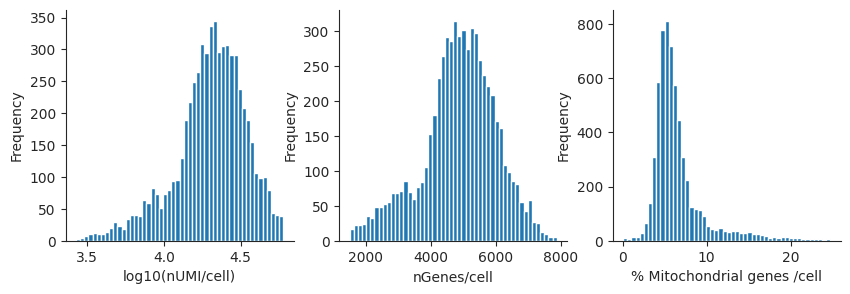

In [31]:
graph_qc(adata)

In [38]:
adata.obs['sample'].value_counts()


,count
sample,
P21_1,3382
P21_2,2736


In [39]:
adata.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
P21_1#AAACCCACAGTCGCAC-1-P21_1,P21_1,5433,26419,1162,4.398350
P21_1#AAACCCAGTAGGTACG-1-P21_1,P21_1,3814,14427,972,6.737367
P21_1#AAACCCATCGAACTCA-1-P21_1,P21_1,4931,20205,2241,11.091314
P21_1#AAACCCATCGCCTCTA-1-P21_1,P21_1,5044,24651,1216,4.932863
P21_1#AAACGAAAGATGCAGC-1-P21_1,P21_1,2890,8803,421,4.782461
...,...,...,...,...,...
P21_2#TTTGATCCATGACTGT-1-P21_2,P21_2,4674,19084,1153,6.041710
P21_2#TTTGATCTCGGACAAG-1-P21_2,P21_2,2057,4495,327,7.274750
P21_2#TTTGGTTGTCTGCGCA-1-P21_2,P21_2,5224,24847,1773,7.135670
P21_2#TTTGGTTTCGTAGCCG-1-P21_2,P21_2,5063,19482,3315,17.015707


In [40]:
adata.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Xkr4,False,1828,0.244530,80.000000,2235
Gm1992,False,50,0.006127,99.452954,56
Gm37381,False,0,0.000000,100.000000,0
Rp1,False,1,0.000328,99.989059,3
Rp1-1,False,0,0.000000,100.000000,0
...,...,...,...,...,...
AC168977.1,False,24,0.002626,99.737418,24
PISD,False,6013,1.572101,34.212254,14369
DHRSX,False,2200,0.320788,75.929978,2932
Vmn2r122,False,0,0.000000,100.000000,0


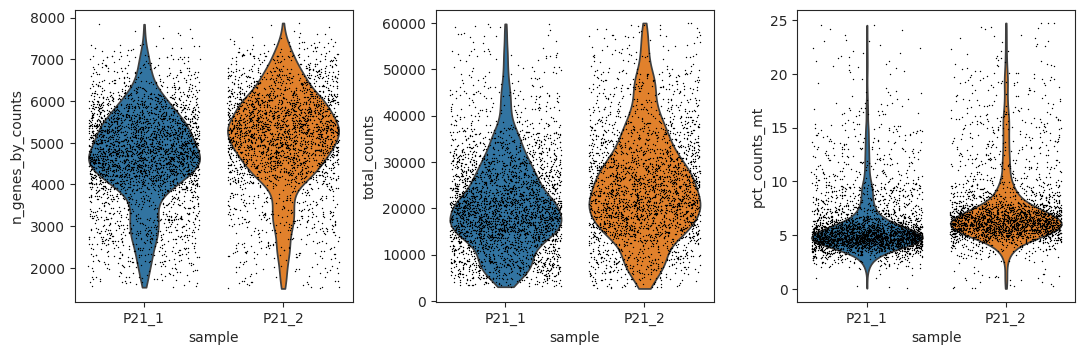

In [22]:
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    groupby='sample',
    jitter=0.4,
    multi_panel=True
)


1. n_genes_by_counts → How many genes are expressed in each cell     
    Too low → likely empty droplet or broken cell
    Too high → likely doublets or dying cells with RNA leakage
2. total_counts → Total UMI counts per cell           
    Too low = low RNA capture
    Too high = potential doublet
3. pct_counts_mt → % reads from mitochondrial gene         
 High mito = stressed or dying cells

In [23]:
adata.X #Sanity check

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 29760908 stored elements and shape (6118, 27998)>

## **Normalize → Regress → Scale → HVG → PCA → Neighbors → Clustering**

In [41]:
sc.pp.filter_genes(adata, min_cells=3)


In [42]:
adata.var


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
Xkr4,False,1828,0.244530,80.000000,2235,1508
Gm1992,False,50,0.006127,99.452954,56,45
Mrpl15,False,5243,1.461816,42.636761,13361,4713
Lypla1,False,3877,0.693654,57.582057,6340,3300
Gm37988,False,37,0.004048,99.595186,37,30
...,...,...,...,...,...,...
CT868723.1,False,4,0.000438,99.956236,4,4
AC168977.1,False,24,0.002626,99.737418,24,17
PISD,False,6013,1.572101,34.212254,14369,4666
DHRSX,False,2200,0.320788,75.929978,2932,1953


In [43]:
adata = normalize_regress_hvg_manual(adata, n_top_genes=3000)


Data looks raw. Normalizing and log-transforming...
Filtering low-expressed genes...
Top 3000 highly variable genes flagged (cell_ranger).
Regressing out pct_counts_mt...


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:648: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:648: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


In [44]:
adata.var #We didn't subset the data.

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,mean,std
Xkr4,False,1828,0.244530,80.000000,2235,1508,False,0.104863,0.413539,-0.027020,5.596936e-17,0.207735
Gm1992,False,50,0.006127,99.452954,56,45,True,0.005616,0.862281,4.280034,3.082976e-18,0.069543
Mrpl15,False,5243,1.461816,42.636761,13361,4713,False,0.537812,0.262220,-0.988838,-1.187801e-16,0.366491
Lypla1,False,3877,0.693654,57.582057,6340,3300,False,0.278318,0.341081,-0.485797,1.998329e-16,0.306182
Gm37988,False,37,0.004048,99.595186,37,30,False,0.001790,0.425154,-0.324861,-1.311392e-19,0.027588
...,...,...,...,...,...,...,...,...,...,...,...,...
AC132444.6,False,9,0.000985,99.901532,9,8,False,0.000393,0.310778,-1.002840,2.163265e-19,0.011050
AC168977.1,False,24,0.002626,99.737418,24,17,False,0.000777,0.305678,-1.052459,4.391568e-19,0.015415
PISD,False,6013,1.572101,34.212254,14369,4666,False,0.541217,0.330539,0.875624,2.168274e-16,0.416190
DHRSX,False,2200,0.320788,75.929978,2932,1953,False,0.144067,0.415301,0.374020,-7.326782e-18,0.244315


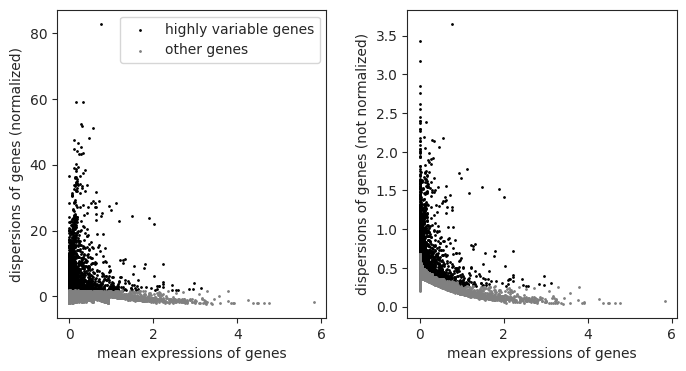

In [45]:
sc.pl.highly_variable_genes(adata)


**Stabilize Variance:** The log transformation helps to stabilize the variance of gene expression across cells, making the data more suitable for statistical analysis.

In [46]:
genes_to_remove = [
    'Xist', 'Gm13305', 'Tsix', 'Eif2s3y', 'Ddx3y', 'Uty',  # sex-specific genes
    'Fos', 'Jun', 'Junb', 'Egr1'                           # immediate early genes
]


**Sex-specific genes (like Xist, Uty, Ddx3y) could split cells artificially by male/female origin instead of biology.

Immediate early genes (like Fos, Jun) spike with stress, dissociation artifacts — not true cell type identity.

Removing these makes clustering based purely on real neuronal identity — not stress or sex differences.**

In [ ]:
# 1. Remove sex and stress genes from HVGs
# 2. PCA
# 3. kNN graph
# 4. Leiden clustering
# 5. UMAP visualization


**Now filter HVGs:**

In [47]:
# Only keep HVGs that are NOT in genes_to_remove
hvgs = adata.var[adata.var['highly_variable']].index.tolist()
hvgs = [gene for gene in hvgs if gene not in genes_to_remove]

# Update the .var['highly_variable'] flags
adata.var['highly_variable'] = adata.var_names.isin(hvgs)
print(f"Number of HVGs after removing unwanted genes: {adata.var['highly_variable'].sum()}")


Number of HVGs after removing unwanted genes: 2992


In [48]:
print(f"Original number of cells: {adata.n_obs}")
adata = adata[adata.obs['total_counts'] > 0].copy()
print(f"Number of cells after removing zero-count cells: {adata.n_obs}")


Original number of cells: 6118
Number of cells after removing zero-count cells: 6118


In [49]:
sc.tl.pca(adata, use_highly_variable=True, n_comps=50)
#sc.tl.pca(adata, mask_var="highly_variable", n_comps=50)


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [50]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
#Build kNN graph in PCA space (50 PCs)

In [51]:
# Leiden Clustering with Resolution 1.5
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_1.5')


<ipython-input-51-8c2ec4366f2f>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.5, key_added='leiden_1.5')


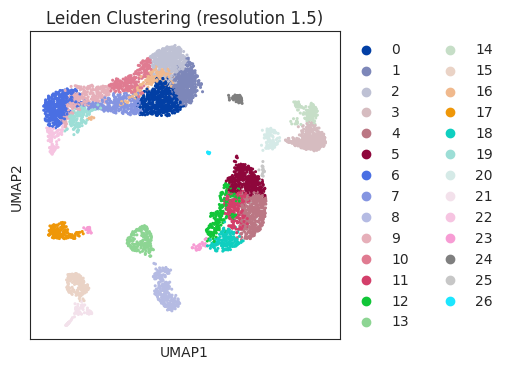

In [52]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden_1.5', title='Leiden Clustering (resolution 1.5)') #: tries to split finer.


Higher values lead to more clusters, while lower values result in fewer, more aggregated clusters. This allows you to adjust the granularity of the cell populations identified by Leiden clustering.

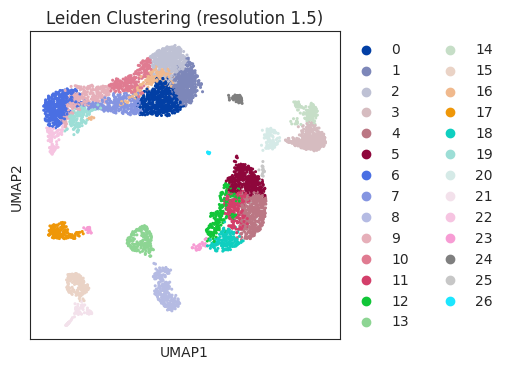

In [53]:
sc.pl.umap(adata, color='leiden_1.5', title='Leiden Clustering (resolution 1.5)') # favors coarser (bigger) clusters.


If the structure in the kNN graph is strong, clusters are stable even across a range of resolutions.

Especially when n_neighbors is small relative to dataset size.    
resolution->	How "finely" Leiden splits (higher splits more).   
n_neighbors->	How connected the cells are (more neighbors = fuzzier structure).  
n_pcs->	PCA space resolution (important for shape of graph)

**canonical marker genes used to interpret cell identity and quality in the enteric nervous system (ENS)**
Elavl4	All neurons->	Exclude glia.     
Sox10, Gfap	Glia->	Remove glial contamination.     
Chat	Cholinergic neuron->	Define motor neuron subtype     
Nos1	Nitrergic neuron->	Define inhibitory subtype


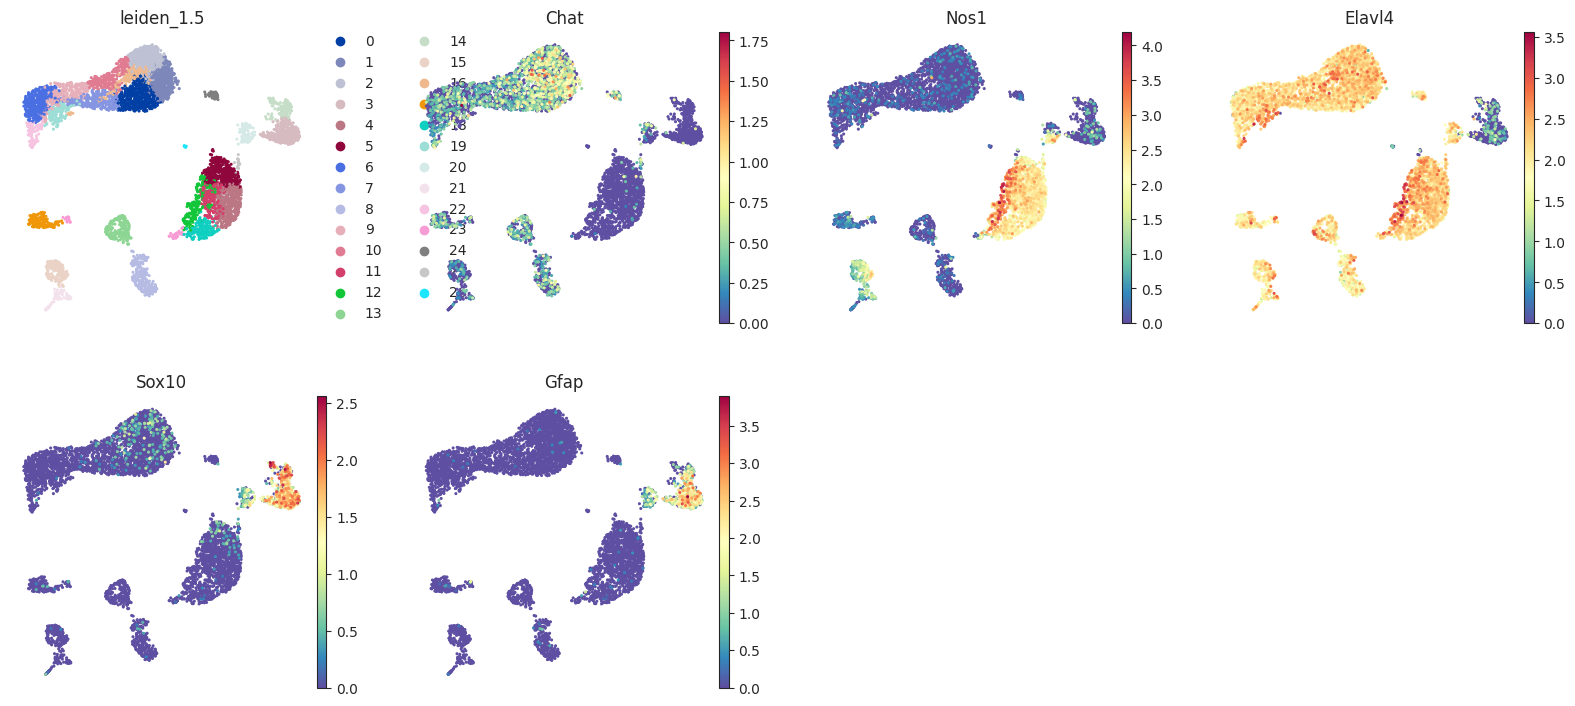

In [54]:
sc.pl.umap(adata, color=['leiden_1.5', 'Chat', 'Nos1', 'Elavl4', 'Sox10', 'Gfap'], frameon=False)


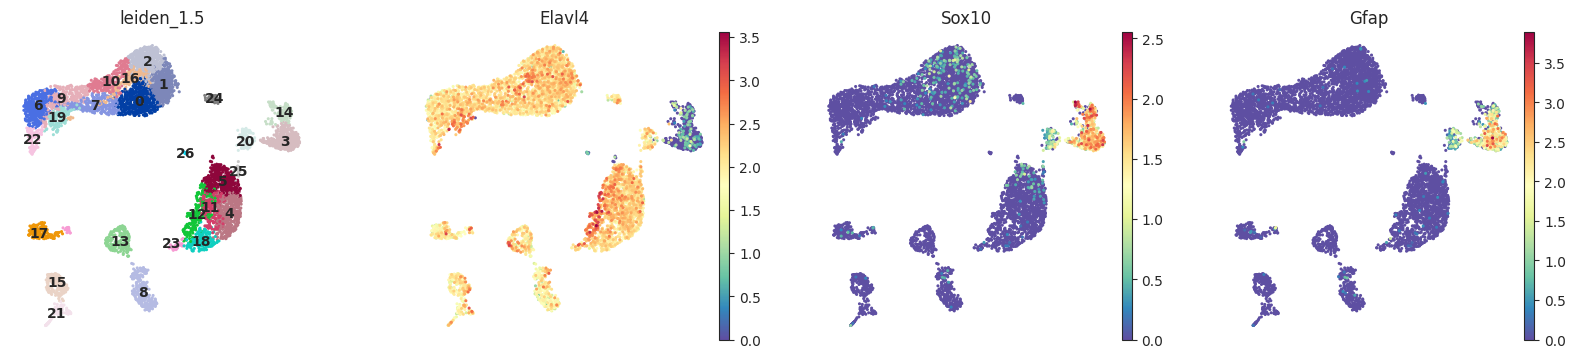

In [55]:
sc.pl.umap(adata, legend_loc='on data', color=['leiden_1.5', 'Elavl4', 'Sox10', 'Gfap'], frameon=False)
#Sox10, Gfap (glia markers)

In [57]:
# Save a backup copy
adata_filter1 = adata.copy()  # FULL object, no cells lost
#adata = adata_full.copy()


In [58]:
adata.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden_1.5
P21_1#AAACCCACAGTCGCAC-1-P21_1,P21_1,5433,26419,1162,4.398350,10
P21_1#AAACCCAGTAGGTACG-1-P21_1,P21_1,3814,14427,972,6.737367,8
P21_1#AAACCCATCGAACTCA-1-P21_1,P21_1,4931,20205,2241,11.091314,24
P21_1#AAACCCATCGCCTCTA-1-P21_1,P21_1,5044,24651,1216,4.932863,0
P21_1#AAACGAAAGATGCAGC-1-P21_1,P21_1,2890,8803,421,4.782461,3
...,...,...,...,...,...,...
P21_2#TTTGATCCATGACTGT-1-P21_2,P21_2,4674,19084,1153,6.041710,2
P21_2#TTTGATCTCGGACAAG-1-P21_2,P21_2,2057,4495,327,7.274750,3
P21_2#TTTGGTTGTCTGCGCA-1-P21_2,P21_2,5224,24847,1773,7.135670,6
P21_2#TTTGGTTTCGTAGCCG-1-P21_2,P21_2,5063,19482,3315,17.015707,24


In [61]:
# Define clusters you want to REMOVE
# removing glia
remove_clusters = ['14', '3', '20']

# Keep only cells NOT in these clusters
adata = adata[~adata.obs['leiden_1.5'].isin(remove_clusters)].copy()

print(f"Remaining cells after removing clusters {remove_clusters}: {adata.n_obs}")


Remaining cells after removing clusters ['14', '3', '20']: 5375


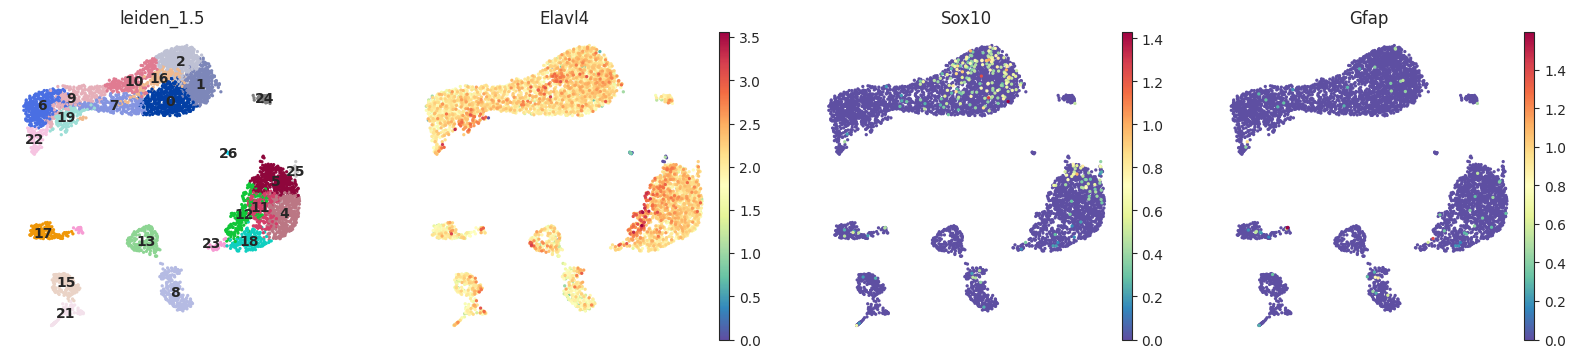

In [62]:
sc.pl.umap(adata, legend_loc='on data', color=['leiden_1.5', 'Elavl4', 'Sox10', 'Gfap'], frameon=False)
#Sox10, Gfap (glia markers)

In [63]:
sc.tl.tsne(adata)


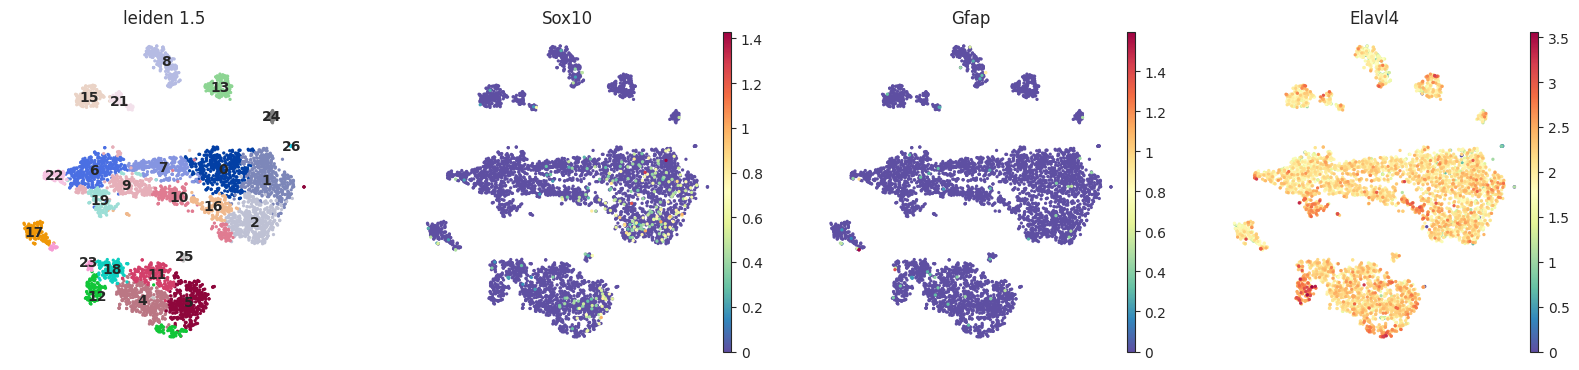

In [64]:
sc.pl.scatter(adata, basis='tsne', legend_loc='on data', color=['leiden_1.5', 'Sox10', 'Gfap', 'Elavl4'], frameon=False)


In [ ]:
print(adata.var_names)


Index(['Xkr4', 'Gm1992', 'Mrpl15', 'Lypla1', 'Gm37988', 'Tcea1', 'Rgs20',
       'Atp6v1h', 'Oprk1', 'Rb1cc1',
       ...
       'mt-Cytb', 'Vamp7', 'Spry3', 'Tmlhe', 'CR974586.5', 'AC132444.6',
       'AC168977.1', 'PISD', 'DHRSX', 'CAAA01147332.1'],
      dtype='object', length=17664)


In [65]:
# Save a backup copy
adata_filter2 = adata.copy()  # FULL object, no cells lost
#adata = adata_full.copy()

In [ ]:
# Check if "Pip1" or any close match exists
[p for p in adata.var_names if "pip" in p.lower()]
#None of these genes in our list are what we should use for filtering glial contamination.

['Vcpip1',
 'Ppip5k2',
 'Pip4k2a',
 'Pip5kl1',
 'Apip',
 'Ppip5k1',
 'Pip5k1a',
 'Pip5k1c',
 'Pip4k2c',
 'Pstpip1',
 'Pipox',
 'Pip4k2b',
 'Pip5k1b']

Pip4k2a, Pip4k2b, Pip5k1a, Pip5k1b, Pip5k1c, etc.
are phosphatidylinositol phosphate kinases, not necessarily glial markers.

Filter clusters based on:
Elavl4 (positive for neurons)

Total UMI counts (good quality)

Low mitochondrial percentage

**Remaining cells are subject to second-level clustering (35 PCs, resolution = 1.0), yielding clear separation of glia and neuron clusters.**

In [66]:
sc.tl.pca(adata, mask_var="highly_variable", n_comps=35)


In [67]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=35)


In [71]:
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_1.0')


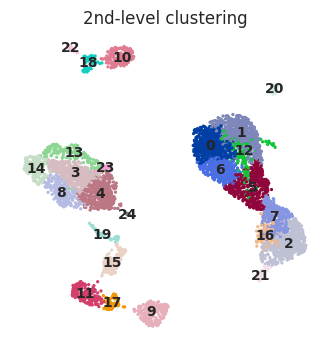

In [72]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden_1.5', legend_loc='on data', frameon=False, title='2nd-level clustering')


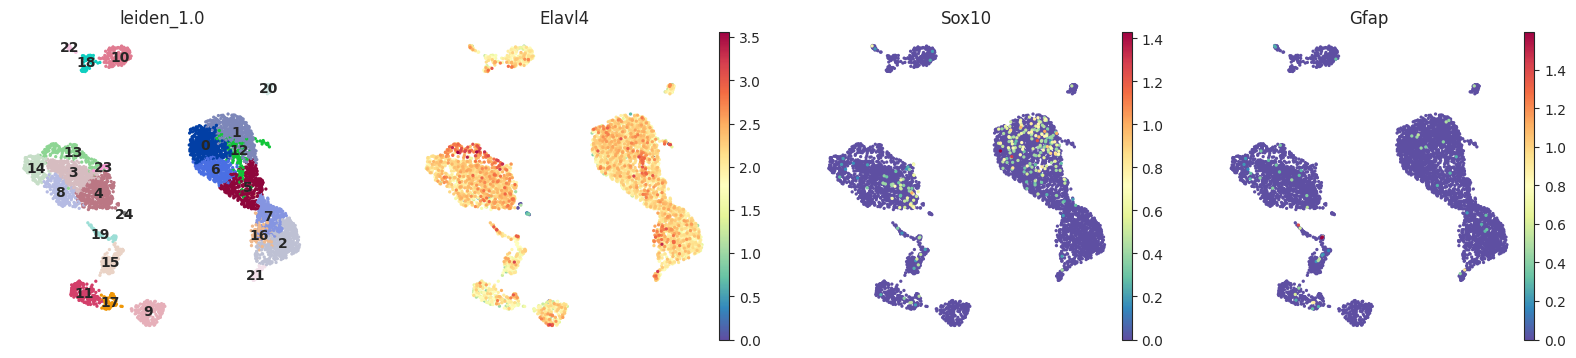

In [73]:
sc.pl.umap(adata, legend_loc='on data', color=['leiden_1.5', 'Elavl4', 'Sox10', 'Gfap'], frameon=False)


Inspect clusters with elevated Sox10 (> 0.4):

Plot UMAP: color=['Sox10', 'Elavl4']

Label by cluster (leiden_1.0)

Check if those clusters also have:

Low Elavl4

High pct_counts_mt

Low n_genes_by_counts or total_counts

If 2 or more signs of glial identity, remove those clusters

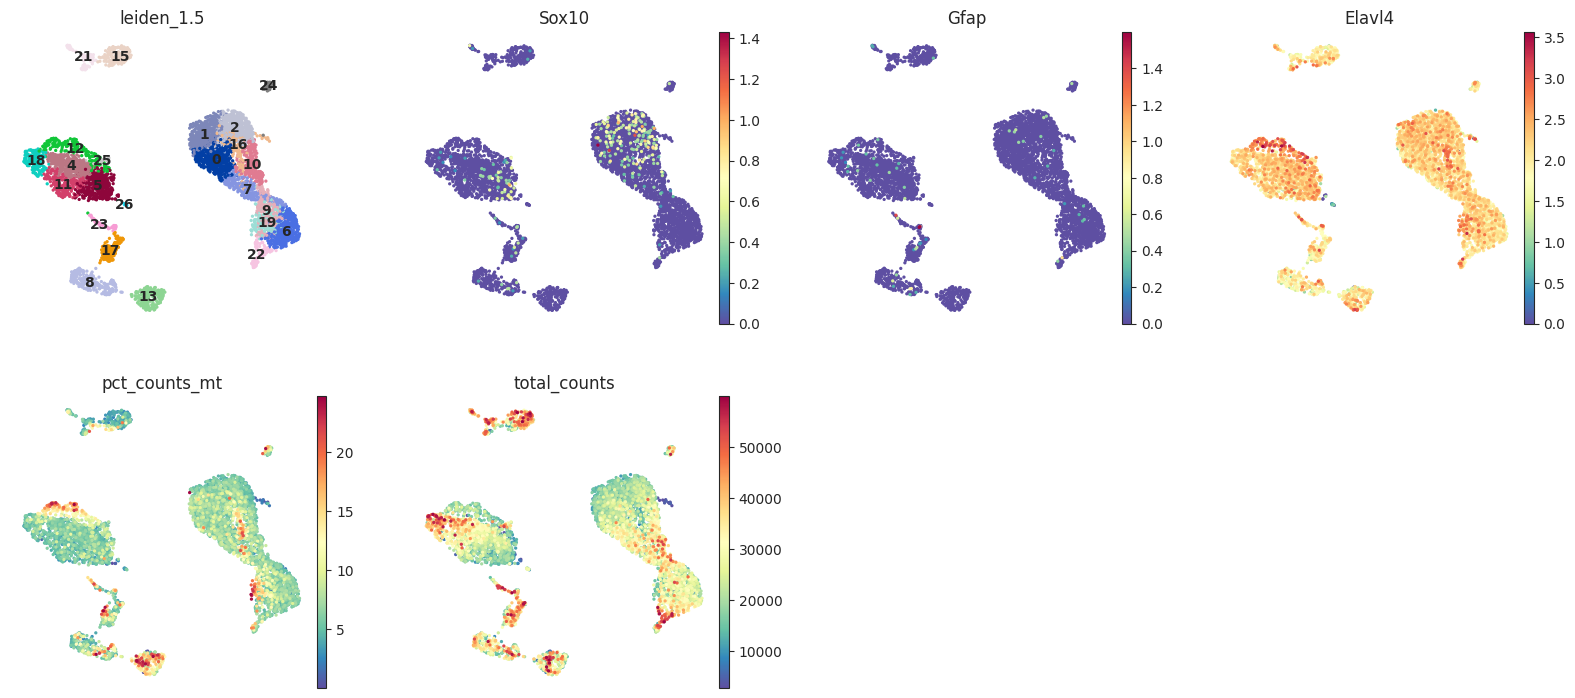

In [76]:
sc.pl.umap(
    adata,legend_loc='on data',
    color=['leiden_1.5', 'Sox10', 'Gfap', 'Elavl4', 'pct_counts_mt', 'total_counts'],
    frameon=False
)


Don't see anything too bad here.

In [77]:
# Define clusters you want to REMOVE
# removing glia

remove_clusters = ['16']

# Keep only cells NOT in these clusters
adata = adata[~adata.obs['leiden_1.0'].isin(remove_clusters)].copy()

print(f"Remaining cells after removing clusters {remove_clusters}: {adata.n_obs}")

Remaining cells after removing clusters ['16']: 5282


**Third Level Clustering**

In [78]:
sc.tl.pca(adata, mask_var="highly_variable", n_comps=30)


In [80]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)


In [98]:
sc.tl.leiden(adata, resolution=0.4, key_added='leiden_0.4')


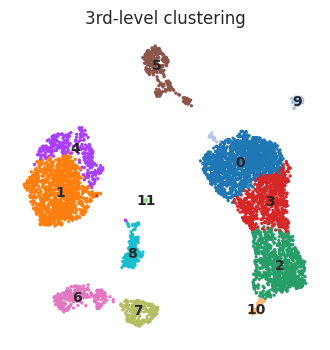

In [99]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden_0.4', legend_loc='on data', frameon=False, title='3rd-level clustering')


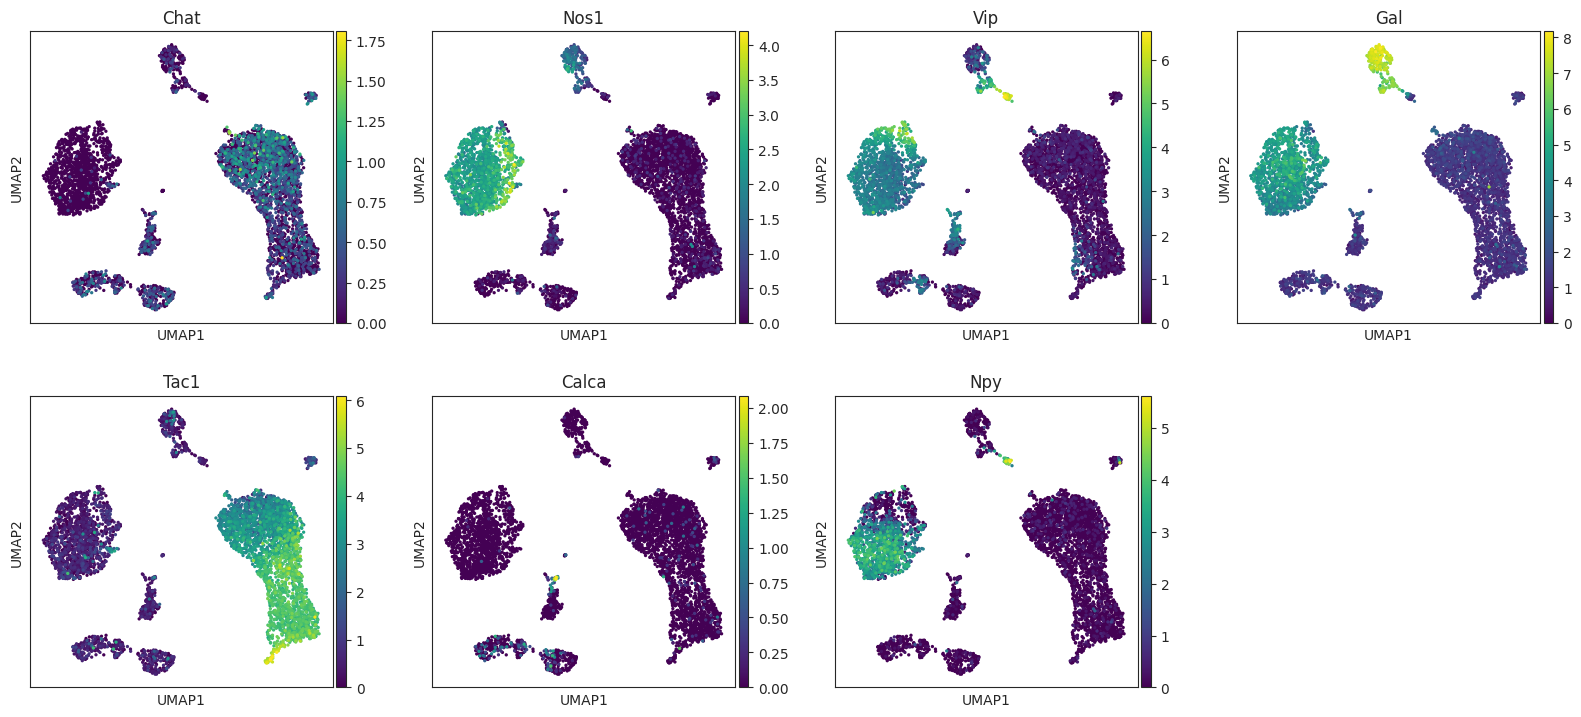

In [100]:
sc.pl.umap(adata, color=['Chat', 'Nos1', 'Vip', 'Gal', 'Tac1', 'Calca', 'Npy'], cmap='viridis')


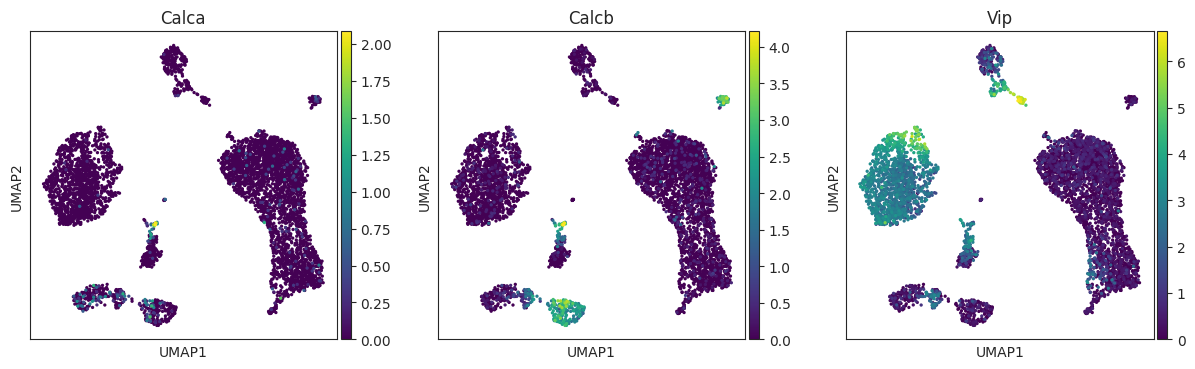

In [120]:
sc.pl.umap(adata, color=['Calca', 'Calcb',"Vip"], cmap='viridis')



cluster:0 :ENC1, 1,4: ENC4,

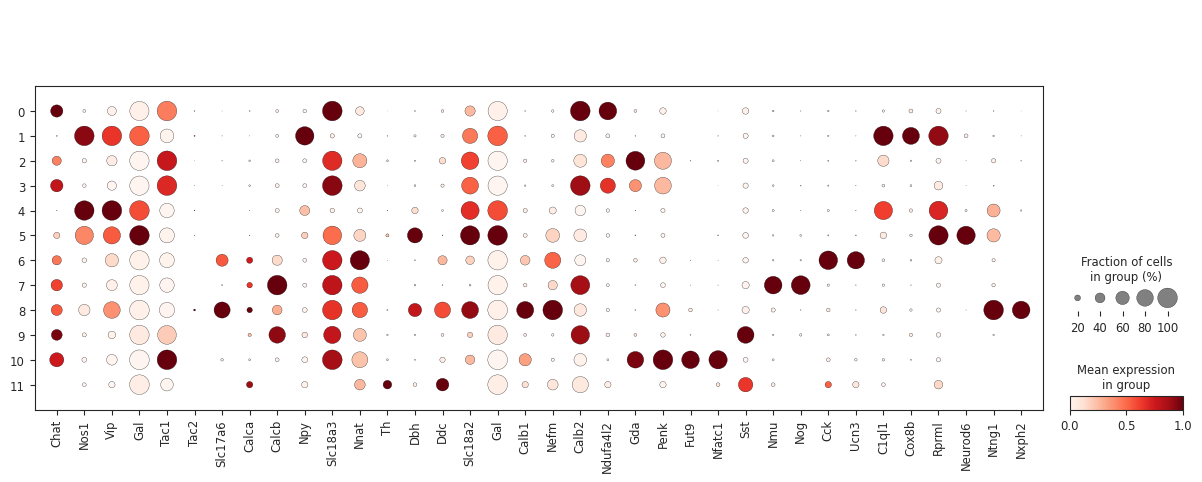

In [121]:
sc.pl.dotplot(
    adata,
    var_names=[
        'Chat', 'Nos1', 'Vip', 'Gal', 'Tac1', 'Tac2',
        'Slc17a6', 'Calca', 'Calcb', 'Npy', 'Slc18a3', 'Nnat','Th', 'Dbh', 'Ddc', 'Slc18a2'
        , 'Calb1', 'Nefm', 'Calb2', 'Ndufa4l2', 'Gda', 'Penk', 'Fut9', 'Nfatc1', 'Sst',
        'Nmu', 'Nog', 'Cck', 'Ucn3', 'C1ql1', 'Cox8b', 'Rprml', 'Neurod6',
        'Ntng1', 'Nxph2'
    ],
    groupby='leiden_0.4',  # Replace with your final cluster key
    standard_scale='var',  # Scale across genes for comparability
)


In [102]:
marker_dict = {
    'Cholinergic': ['Chat', 'Slc18a3'],
    'Nitrergic': ['Nos1'],
    'GABAergic': ['Gad2'],
    'Glutamatergic': ['Slc17a6'],
    'Catecholaminergic': ['Th', 'Dbh'],
    'Serotonergic': ['Ddc', 'Slc18a2'],
    'Other': ['Gal', 'Vip', 'Calcb', 'Calb1', 'Nefm'],
    'Distinguishing': [
        'Tac1', 'Calb2', 'Ndufa4l2', 'Gda', 'Penk', 'Fut9', 'Nfatc1', 'Sst',
        'Nmu', 'Nog', 'Cck', 'Ucn3', 'C1ql1', 'Cox8b', 'Npy', 'Rprml', 'Neurod6',
        'Ntng1', 'Nxph2'
    ]
}


ENC1 = Calb2, Ndufa4l2 ENC2 = Calb2, Gda/Penk, Ndufa4l2 ENC3 = Calb2-, Gda/Penk, Ndufa4l2 ENC4 = Fut9, Gda/Penk, Calb2- ENC8 = Nos1, Npy, Rprml ENC9 = Nos1, Npy-, Rprml ENC10 = Gad2, Neurod6, Rprml ENC5 = Sst, Calb2, Calcb ENC6 = Nmu, Calb2, Calcb ENC7 = Ucn3, Cck, vGlut2 ENC12 = Nxph2, Ntng1, Calb1, vGlut2 ENC11 = Npy, Th, Dbh, Calb2

In [122]:
cell_types = pd.Series("", index=adata.obs['leiden_0.4'].values.categories)
cell_types['0'] = 'ENC5'
cell_types['1'] = 'ENC8'
cell_types['2'] = 'ENC7'
cell_types['3'] = 'ENC3'
cell_types['4'] = 'ENC2'
cell_types['5'] = 'ENC1'
cell_types['6'] = 'ENC10'
cell_types['7'] = 'ENC9'
cell_types['8'] = 'ENC6'
cell_types['9'] = 'ENC11'
cell_types['10'] = 'ENC4'
cell_types['11'] = 'ENC12'

In [123]:
adata.obs['celltype'] = cell_types[adata.obs['leiden_0.4']].values


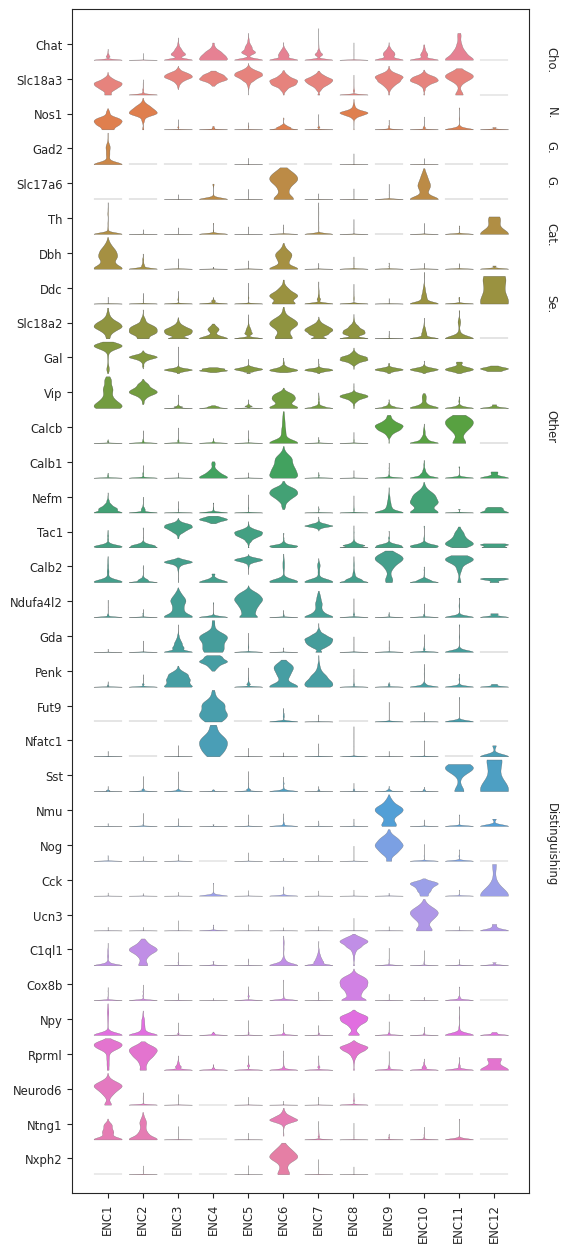

In [124]:
sc.pl.stacked_violin(
    adata,
    marker_dict,
    groupby='celltype',
    swap_axes=True,
    row_palette='husl',
    figsize=(8, 15)
)


In [ ]:
'''| **Cluster** | **Marker Genes**                | **Interpretation**                                    | **Suggested Label**                   |
| ----------- | ------------------------------- | ----------------------------------------------------- | ------------------------------------- |
| **0**       | `Slc18a3`, `Calb2`, `Ndufa4l2`  | Cholinergic sensory-like; Calb2+ often sensory        | **ENC5 - Cholinergic sensory**        |
| **1**       | `Nos1`, `Npy`, `C1ql1`, `Rprml` | Nitrergic + Npy (suggests inhibitory); C1ql1+ dev?    | **ENC8 - Nitrergic inhibitory**       |
| **2**       | `Gda`, `Tac1`                   | Sensory/interneuron; Tac1 strong marker for ENC7      | **ENC7 - Sensory/interneuron**        |
| **3**       | `Slc18a3`, `Calb2`, `Tac1`      | Strong cholinergic sensory signature                  | **ENC3 - Cholinergic sensory**        |
| **4**       | `Nos1`, `Vip`                   | Classic nitrergic + VIP motor neuron                  | **ENC2 - Nitrergic inhibitory motor** |
| **5**       | `Slc18a3`, `Gal`                | Cholinergic with Gal suggests motor identity          | **ENC1 - Cholinergic motor**          |
| **6**       | `Nnat`, `Cck`                   | Peptidergic sensory-like neurons (Calca/Calcb family) | **ENC10 - Peptidergic sensory**       |



| **Cluster** | **Marker Genes**                                       | **Interpretation**                                               | **Suggested Label**                      |
| ----------- | ------------------------------------------------------ | ---------------------------------------------------------------- | ---------------------------------------- |
| **7**       | `Calcb`, `Slc18a3`, `Calb2`, `Nmu`, `Nog`, (low `Gal`) | Cholinergic + neuropeptides (Nmu/Nog); similar to visceral ENC9  | **ENC9 - Visceral motor**                |
| **8**       | `Slc17a6`, `Nefm`, `Ntng1`, `Nxph2`                    | Glutamatergic + projection neuron-like markers                   | **ENC6 - Glutamatergic/projection-like** |
| **9**       | `Calb2`, `Sst`, `Calcb`                                | Peptidergic sensory neuron subtype                               | **ENC11 - Peptidergic sensory**          |
| **10**      | `Tac1`, `Penk`, `Slc18a3`, `Gda`, `Nfatc1`, `Fut9`     | Interneuron markers + cholinergic → complex motor/sensory hybrid | **ENC4 - Interneuron hybrid**            |
| **11**      | Low `Gal`, `Calb1`                                     | Less distinctive; Calb1+ may hint at subtype of sensory          | **ENC12 - Sensory/undefined subtype**    |

'''




In [125]:
adata3 = adata.copy()

In [126]:
adata.write('/content/drive/MyDrive/ENS-Monal/my_adata_file.h5ad')
#load it later:
#import scanpy as sc
#adata = sc.read("my_adata_file.h5ad")